In [106]:
import os
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

yf.pdr_override()

pd.set_option('chained_assignment',None)

In [107]:
today = dt.datetime.today()
last_month = dt.datetime.today() - dt.timedelta(days=30)
year = today.year - 1

# list of financial parametrs in ticker data object that I care about
financials_list = ['previousClose','marketCap','trailingPE','forwardPE','priceToBook',
                   'pegRatio','forwardEps','beta','shortPercentOfFloat','shortRatio',
                  'bookValue']

In [112]:
def price_to_sales(ticker): # calculate price to sales ratio based on market cap and TTM reveunue
    # convert CNY to USD if company is based in China, double check Yahoo Finance to confirm currency revenue is reported in
    sales_usd = 0
    if ticker.info['country'] == 'China':
        cny = pdr.FredReader("DEXCHUS",start=last_month,end=today).read()
        cny_to_usd = cny['DEXCHUS'].mean()
        sales_usd = ticker.quarterly_earnings['Revenue'].sum() / cny_to_usd
    # skip straight to p / s calc if not from China
    else:
        sales_usd = ticker.quarterly_earnings['Revenue'].sum()
    return ticker.info['marketCap'] / sales_usd

def return_on_equity(ticker): # calculate shareholder return on equity based on book value and TTM reveunue
    # convert CNY to USD if company is based in China, double check Yahoo Finance to confirm currency revenue is reported in
    sales_usd = 0
    if ticker.info['country'] == 'China':
        cny = pdr.FredReader("DEXCHUS",start=last_month,end=today).read()
        cny_to_usd = cny['DEXCHUS'].mean()
        earnings_usd = ticker.quarterly_earnings['Earnings'].sum() / cny_to_usd
    # skip straight to p / s calc if not from China
    else:
        earnings_usd = ticker.quarterly_earnings['Earnings'].sum()
    
    try:
        return earnings_usd / ticker.info['bookValue']
    
    except:
        return 0.0
    

def make_data_frame(company_names, financials_list):
    # pull raw data form yahoo finance
    raw_yfin_data = yf.Tickers(company_names)
    df = pd.DataFrame(index=raw_yfin_data.symbols,columns=financials_list)
    for stock in df.index:
        # build dataframe from the parameters I care about
        for data in financials_list:
            try:
                df[data][stock] = getattr(raw_yfin_data.tickers, stock).info[data]
            except:
                df[data][stock] = 0.0
            
        df.loc[stock, 'pricetoSales'] = price_to_sales(getattr(raw_yfin_data.tickers, stock))
        df.loc[stock, 'returnonEquity'] = return_on_equity(getattr(raw_yfin_data.tickers, stock))

    # add price to sales calculation to each stock        
    #for stock in df.index:
    #    df.loc[stock, 'pricetoSales'] = price_to_sales(getattr(raw_yfin_data.tickers, stock))

    return df

In [187]:
# inputs for sectors and tickers to track
sectors = {
    'ev' : ['TSLA','NIO','F'],
    'fintech' : ['SQ','LMND','PYPL','RKT','PINS','Z','JPM','MET','ALL'],
    'bio'  : ['PACB','TDOC','CDNA'],
    'tech' : ['FB', 'AAPL', 'GOOG', 'AMZN', 'TWTR'],
    'auto' : ['CVNA','SFT','VRM'],
    're' : ['ZG','RDFN','OPEN']
}

In [188]:
ev_df, fintech_df, bio_df, tech_df, auto_df, re_df = [ make_data_frame(sectors[sector],financials_list) for sector in sectors ]

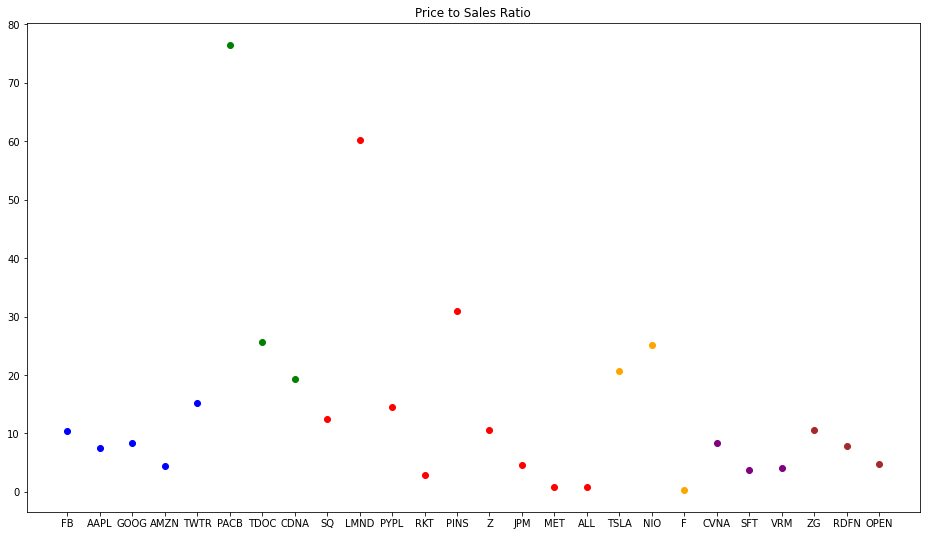

In [189]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(tech_df.index, tech_df['pricetoSales'], facecolor='blue')
ax.scatter(bio_df.index, bio_df['pricetoSales'], facecolor='green')
ax.scatter(fintech_df.index, fintech_df['pricetoSales'], facecolor='red')
ax.scatter(ev_df.index, ev_df['pricetoSales'], facecolor='orange')
ax.scatter(auto_df.index, auto_df['pricetoSales'], facecolor='purple')
ax.scatter(re_df.index,re_df['pricetoSales'], facecolor='brown')
plt.title('Price to Sales Ratio')
plt.show()

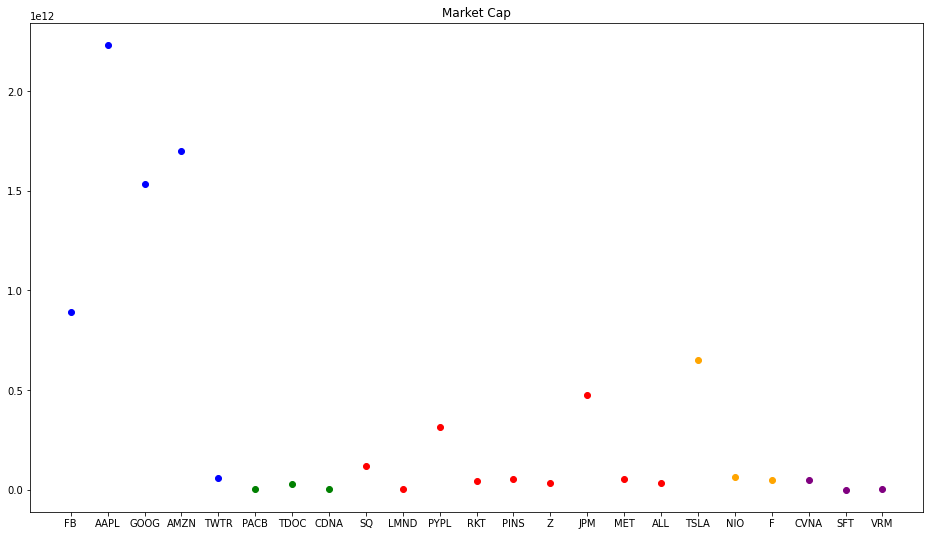

In [190]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(tech_df.index, tech_df['marketCap'], facecolor='blue')
ax.scatter(bio_df.index, bio_df['marketCap'], facecolor='green')
ax.scatter(fintech_df.index, fintech_df['marketCap'], facecolor='red')
ax.scatter(ev_df.index, ev_df['marketCap'], facecolor='orange')
ax.scatter(auto_df.index, auto_df['marketCap'], facecolor='purple')
plt.title('Market Cap')
plt.show()

TSLA


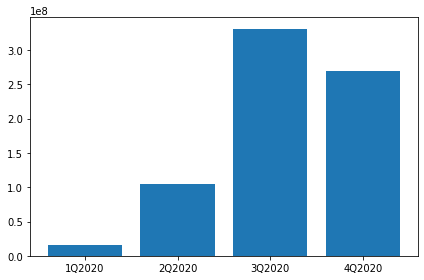

NIO
BLNK


In [155]:
fig, ax = plt.subplots()

# x = np.arange(len(ore_tickers.symbols)) 

# rects1 = ax.bar(ore_tickers.tickers.RKT.quarterly_earnings.index, ore_tickers.tickers.RKT.quarterly_earnings['Earnings'])
# rects2 = ax.bar(ore_tickers.tickers.OPEN.quarterly_earnings.index, ore_tickers.tickers.OPEN.quarterly_earnings['Earnings'])

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Quarterly Revenue')
# ax.set_title('TTM Revenue by Quarter')
# ax.set_xticks(x)
# ax.set_xticklabels(ore_tickers.symbols)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

for stock in sectors['ev']:
    print(stock)
    ticker = yf.Tickers(stock)
    rect = ax.bar(getattr(ticker.tickers, stock).quarterly_earnings.index,
            getattr(ticker.tickers, stock).quarterly_earnings['Earnings'], label=stock)
    fig.tight_layout()
    plt.show()


In [ ]:
def earnings_data_frame(company_names, financials_list):
    # pull raw data form yahoo finance
    raw_yfin_data = yf.Tickers(company_names)
    df = pd.DataFrame(index=raw_yfin_data.symbols,columns=financials_list)
    for stock in df.index:
        # build dataframe from the parameters I care about
        for data in financials_list:
            try:
                df[data][stock] = getattr(raw_yfin_data.tickers, stock).info[data]
            except:
                df[data][stock] = 0.0
            
        df.loc[stock, 'pricetoSales'] = price_to_sales(getattr(raw_yfin_data.tickers, stock))
        df.loc[stock, 'returnonEquity'] = return_on_equity(getattr(raw_yfin_data.tickers, stock))

    # add price to sales calculation to each stock        
    #for stock in df.index:
    #    df.loc[stock, 'pricetoSales'] = price_to_sales(getattr(raw_yfin_data.tickers, stock))

    return df

In [215]:
raw_yfin_data = yf.Tickers(sectors['tech'])
df = pd.DataFrame()
for stock in raw_yfin_data.symbols:
    df[stock] = getattr(raw_yfin_data.tickers, stock).quarterly_earnings['Revenue']

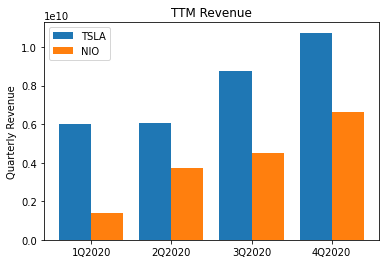

In [174]:
X = df.index
Ygirls = df['TSLA']
Zboys = df['NIO']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'TSLA')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'NIO')
  
plt.xticks(X_axis, X)
plt.ylabel("Quarterly Revenue")
plt.title("TTM Revenue")
plt.legend()
plt.show()

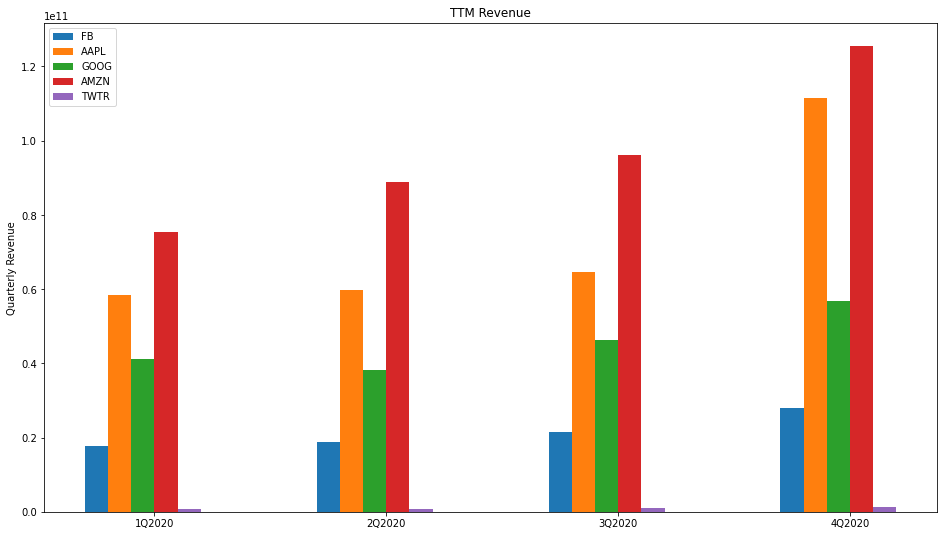

In [217]:
plt.figure(figsize=(16,9))
X = df.index
X_axis = np.arange(len(X))
width = 0.1
n = -1 * len(df.columns) / 2 * width
for stock in df.columns:
    plt.bar(X_axis+n,df[stock],width,label=stock)
    n += width

plt.xticks(X_axis, X)
plt.ylabel("Quarterly Revenue")
plt.title("TTM Revenue")
plt.legend()
plt.show()

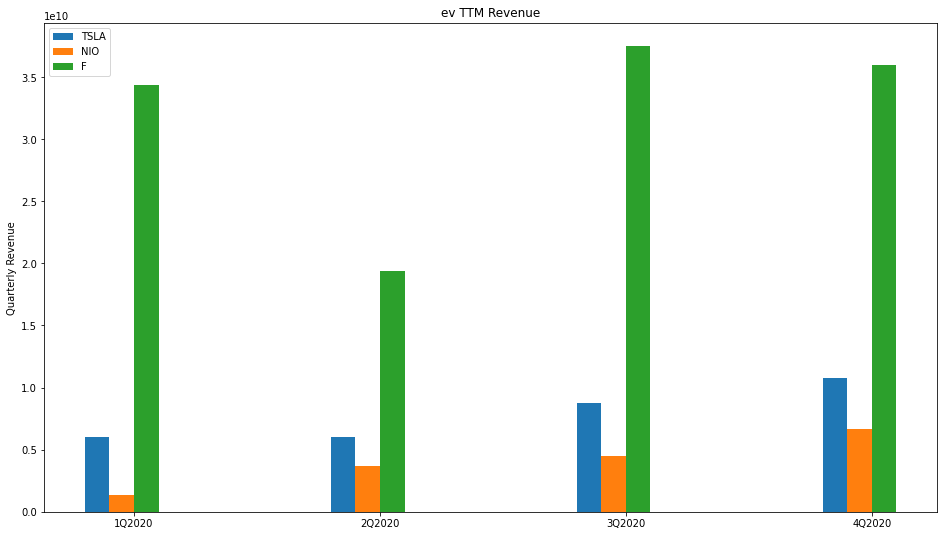

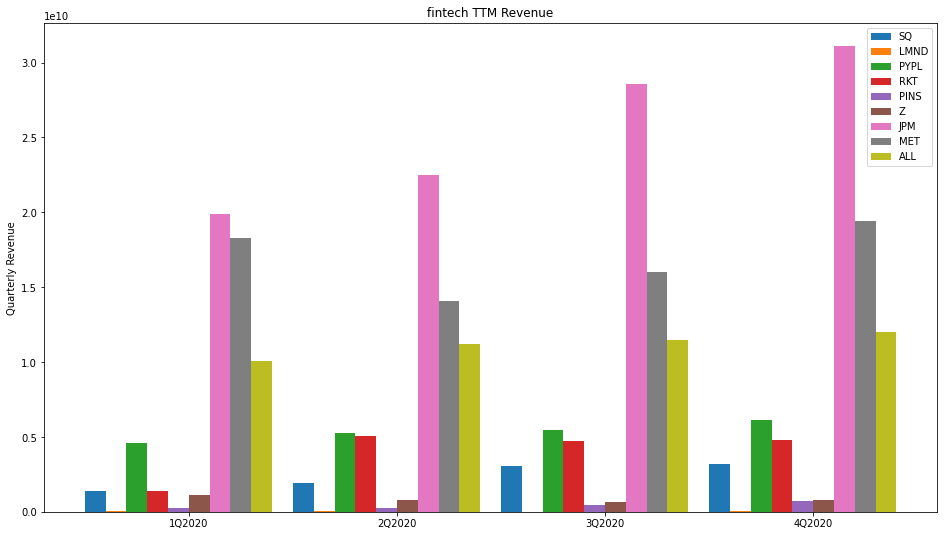

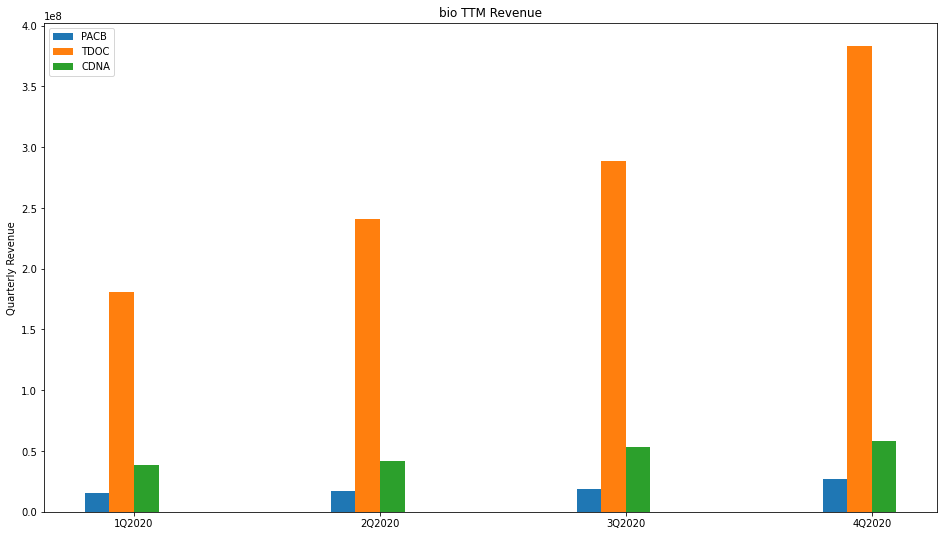

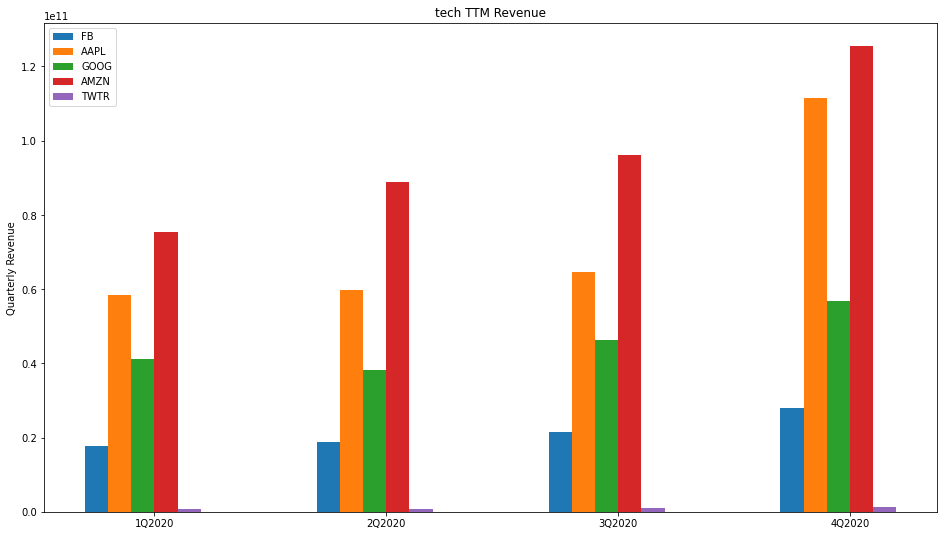

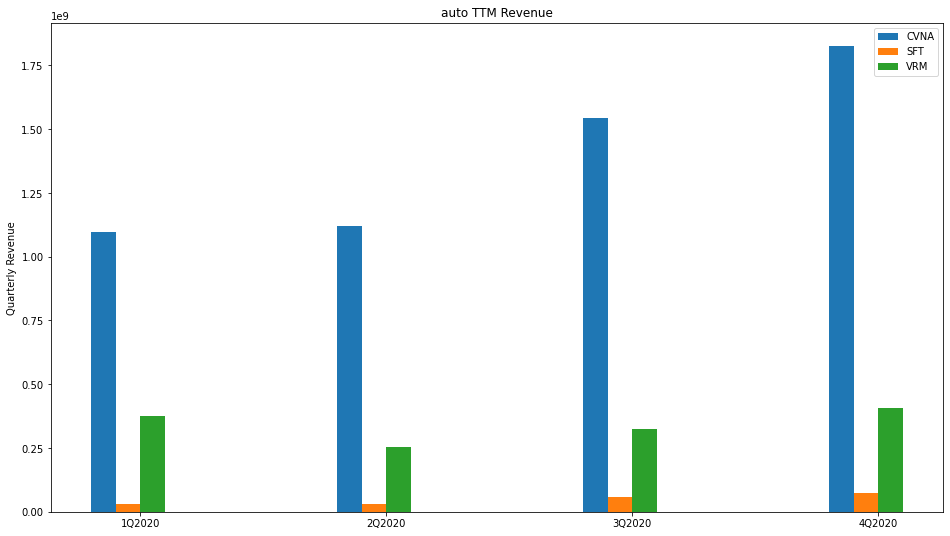

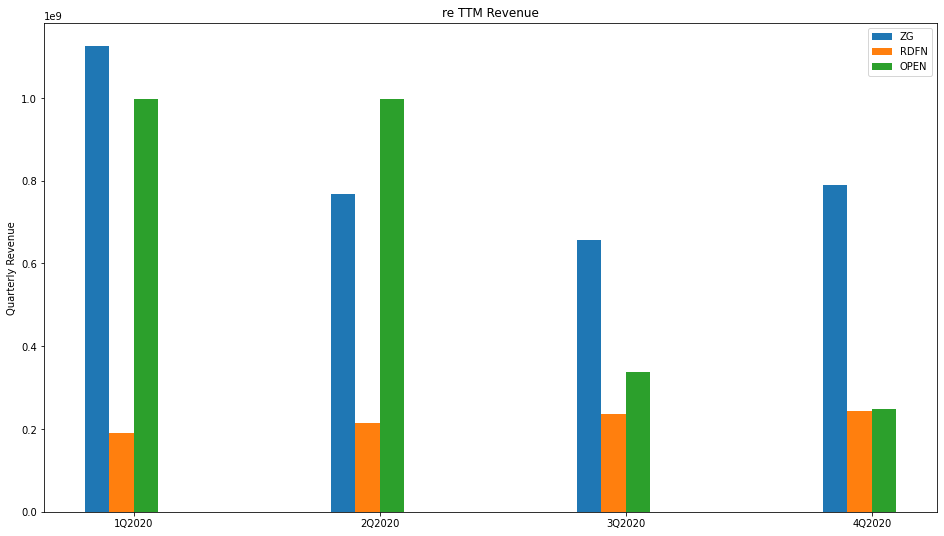

In [225]:
for sector in sectors.keys():
    raw_yfin_data = yf.Tickers(sectors[sector])
    df = pd.DataFrame()
    for stock in raw_yfin_data.symbols:
        df[stock] = getattr(raw_yfin_data.tickers, stock).quarterly_earnings['Revenue']

    plt.figure(figsize=(16,9))
    X = df.index
    X_axis = np.arange(len(X))
    width = 0.1
    n = -1 * len(df.columns) / 2 * width
    for stock in df.columns:
        plt.bar(X_axis+n,df[stock],width,label=stock)
        n += width

    plt.xticks(X_axis, X)
    plt.ylabel('Quarterly Revenue')
    plt.title(sector + ' ' + 'TTM Revenue')
    plt.legend()
    plt.show()

In [ ]:
# how do I build these dataframes more intelligently? 

ev_df = pd.DataFrame(index=ev_tickers.symbols,columns=financials_list)
for stock in ev_tickers.symbols:
    # build dataframe from the parameters I care about
    for data in financials_list:
        try:
            ev_df[data][stock] = getattr(ev_tickers.tickers, stock).info[data]
        except:
            ev_df[data][stock] = 0.0
            
fintech_df = pd.DataFrame(index=fintech_tickers.symbols,columns=financials_list)
for stock in fintech_tickers.symbols:
    # build dataframe from the parameters I care about
    for data in financials_list:
        try:
            fintech_df[data][stock] = getattr(fintech_tickers.tickers, stock).info[data]
        except:
            fintech_df[data][stock] = 0.0
 
# add p/s ratio calc to dataframe
for stock in ev_tickers.symbols:
    ev_df.loc[stock, 'pricetoSales'] = price_to_sales(getattr(ev_tickers.tickers, stock))

# add p/s ratio calc to dataframe
for stock in fintech_tickers.symbols:
    fintech_df.loc[stock, 'pricetoSales'] = price_to_sales(getattr(fintech_tickers.tickers, stock))

In [ ]:
# list of tickers by sector, create yfinance ticker data objects
ev_tickers = yf.Tickers('tsla nio blnk')
fintech_tickers = yf.Tickers('sq lmnd pypl rkt pins z jpm met all')
biotech_tickers = yf.Tickers('pacb tdoc cdna')

In [ ]:
data_frames = { }
for sector in sectors:
    data_frames[sector] = pd.DataFrame(index = sectors[sector], columns = financials_of_interest)
    for ticker in sectors[sector]:
        for financial in financials_of_interest:
            try:
                data_frames[sector][financial][ticker] = getattr(raw_yfin_data.tickers, ticker).info[financial]
            except:
                data_frames[sector][financial][ticker] = 0.0